# Maximisation de la rentabilité d'une installation de stockage

## Importer les données annuelles de la PPE

In [2]:
%load_ext lab_black

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
data = pd.read_excel("historic_data.xlsx")
data = data.drop(["Unnamed: 8", "moyen à considérer comme"], axis=1).set_index("Date")

In [5]:
data.head()

,Consommation (MW),Thermique (MW),Bagasse/charbon (MW),Hydraulique (MW),Photovoltaïque (MW),Eolien (MW),Bioénergies (MW)
Date,,,,,,,
2017-01-01 04:00:00,258.452,29.471,198.937,29.183,-0.434,-0.059,1.353
2017-01-01 05:00:00,251.673,30.472,194.092,26.283,-0.427,-0.060,1.313
2017-01-01 06:00:00,242.021,30.010,181.286,29.805,-0.359,-0.062,1.341
2017-01-01 07:00:00,233.028,24.341,173.220,22.226,11.997,-0.042,1.285
2017-01-01 08:00:00,245.900,14.836,163.957,19.252,46.460,0.030,1.365


In [6]:
data["Fatal (MW)"] = (
    data["Photovoltaïque (MW)"]
    + data["Eolien (MW)"]
    + data["Bioénergies (MW)"]
    + data["Hydraulique (MW)"]
)

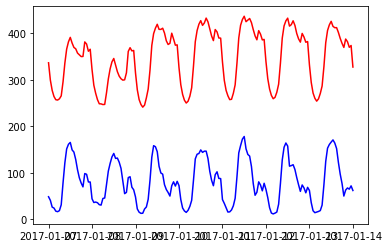

In [7]:
week = data.loc["2017-01-07 00:00":"2017-01-14 00:00"]
demand = week["Consommation (MW)"]
plt.plot(demand, "r")
prod_fatale = week["Fatal (MW)"]
plt.plot(prod_fatale, "b")

costs = np.array([20, 40])
power_max = np.array([400, 200])
power_min = np.array([50, 20])

## La modélisation du problème de rentabilité

On va d'abord définir une colonne FATAL représentant les énergies non dispatchables, incluant l'yhdraulique qui pour le moment sera considéré comme 100% fatal.

In [8]:
data["Fatal (MW)"] = (
    data["Photovoltaïque (MW)"]
    + data["Eolien (MW)"]
    + data["Bioénergies (MW)"]
    + data["Hydraulique (MW)"]
)

In [9]:
df = data.copy()
df.columns = [
    "Consommation",
    "Thermique",
    "Bagasse",
    "Hydraulique",
    "PV",
    "Eolien",
    "Bioenergies",
    "FATAL",
]
df = df.drop(["Hydraulique", "PV", "Eolien", "Bioenergies"], axis=1)

On va alors optimiser la répartition de la production entre thermique, bagasse/charbon et stockage sur des durée d'une semaine. Pour cela nous aurons besoin des capacités de stockage - on considère dans un premier temps qu'il n'y pas de contrainte sur la puissance de charge et décharge du stockage autre qu'une majoration de puissance max, nous expliquerons pourquoi plus loin. Nous aurons aussi besoin des capacités de production du thermique et de la bagasse/charbon, ainsi que leurs contraintes de temps d'arrêt et le coût de production associé.

In [10]:
pmin_ther, pmax_ther = 10, 300
pmin_char, pmax_char = 150, 1100
capa_stock = 550
pmax_stock = 100
cost_ther = 300
cost_char = 150

Cette optimisation par semaine sur l'année nous retournera le coût de production annuel.

Dans un deuxième temps nous aurons besoin d'une évaluation du coût fixe annuel de cette capacité de stockage supplémentaire installée, pour faire un rapport entre le coût évité par une nouvelle installation et ce coût fixe annuel. Il devra prendre en compte notamment le CAPEX répartit sur une durée de vie estimée et l'OPEX associée. 
Nous ne prenons pas en compte l'utilisation du stockage dans l'année sur cette évaluation du coût fixe, alors que cette utilisation peut avoir une grande importance sur la durée de vie (par exemple pour une batterie mal utilisée), mais construire ce modèle serait trop complexe ici.

## Rentabilité d'une installation de stockage

In [11]:
import pulp

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# Récupération d'une semaine
week = df.loc["2017-01-01":"2017-01-07"]
week

,Consommation,Thermique,Bagasse,FATAL
Date,,,,
2017-01-01 04:00:00,258.452,29.471,198.937,30.043
2017-01-01 05:00:00,251.673,30.472,194.092,27.109
2017-01-01 06:00:00,242.021,30.010,181.286,30.725
2017-01-01 07:00:00,233.028,24.341,173.220,35.466
2017-01-01 08:00:00,245.900,14.836,163.957,67.107
...,...,...,...,...
2017-01-07 19:00:00,350.045,92.799,186.517,69.846
2017-01-07 20:00:00,381.292,95.241,186.704,98.462
2017-01-07 21:00:00,376.769,92.802,186.232,96.850


In [42]:
def solve_week(week, **kwargs):
    pmin_ther = kwargs["pmin_ther"] if "pmin_ther" in kwargs.keys() else 10
    pmax_ther = kwargs["pmax_ther"] if "pmax_ther" in kwargs.keys() else 300
    pmin_char = kwargs["pmin_char"] if "pmin_char" in kwargs.keys() else 150
    pmax_char = kwargs["pmax_cahr"] if "pmax_char" in kwargs.keys() else 1100
    capa_stock = kwargs["capa_stock"] if "capa_stock" in kwargs.keys() else 550
    pmax_stock = kwargs["pmax_stock"] if "pmax_stock" in kwargs.keys() else 100
    cost_ther = kwargs["cost_ther"] if "cost_ther" in kwargs.keys() else 300
    cost_char = kwargs["cost_char"] if "cost_char" in kwargs.keys() else 150

    df = week.copy()
    tprob = pulp.LpProblem("Week", pulp.LpMinimize)
    demand = list(week["Consommation"])
    fatal = list(week["FATAL"])
    nbsteps = week.shape[0]
    ## production
    p_ther = [pulp.LpVariable(f"p_ther_{t}", 0, pmax_ther) for t in range(0, nbsteps)]
    p_char = [pulp.LpVariable(f"p_char_{t}", 0, pmax_char) for t in range(0, nbsteps)]
    p_load = [pulp.LpVariable(f"p_load_{t}", 0, pmax_stock) for t in range(0, nbsteps)]
    stock = [pulp.LpVariable(f"stock_{t}", 0, capa_stock) for t in range(0, nbsteps)]

    ## on/off
    on_ther = [
        pulp.LpVariable(f"on_ther_{t}", cat=pulp.LpBinary) for t in range(0, nbsteps)
    ]
    on_char = [
        pulp.LpVariable(f"on_char_{t}", cat=pulp.LpBinary) for t in range(0, nbsteps)
    ]
    on_load = [
        pulp.LpVariable(f"on_load_{t}", cat=pulp.LpBinary) for t in range(0, nbsteps)
    ]

    # constraints
    for t in range(0, nbsteps):
        tprob += p_ther[t] >= pmin_ther * on_ther[t]  # if 'on' produce at least min
        tprob += (
            p_ther[t] <= pmax_ther * on_ther[t]
        )  # if 'on' produce at most max, if 'off' produce 0
        tprob += p_char[t] >= pmin_char * on_char[t]
        tprob += p_char[t] <= pmax_char * on_char[t]
        tprob += p_load[t] >= 0 * on_load[t]
        tprob += p_load[t] <= pmax_stock * on_load[t]

        tprob += p_load[t] <= stock[t - 1]
        tprob += p_ther[t] + p_char[t] + fatal[t] + p_load[t] >= demand[t]

    for t in range(1, nbsteps):
        tprob += stock[t] == stock[t - 1] - p_load[t - 1] + (
            p_load[t - 1] + p_ther[t - 1] + p_char[t - 1] + fatal[t - 1] - demand[t - 1]
        )

    # Add constraints on stopping time

    # objective
    tprob += sum(
        [p_ther[t] * cost_ther + p_char[t] * cost_char for t in range(0, nbsteps)]
    )
    tprob.solve()
    df["Pred_thermique"] = [pulp.value(p_ther[t]) for t in range(0, nbsteps)]
    df["Pred_charbon"] = [pulp.value(p_char[t]) for t in range(0, nbsteps)]
    df["Puissance_stock"] = [pulp.value(p_load[t]) for t in range(0, nbsteps)]
    df["Stockage"] = [pulp.value(stock[t]) for t in range(0, nbsteps)]

    # df.assign(Pred_thermique=[pulp.value(p_ther[t]) for t in range(0, nbsteps)],
    #         Pred_charbon= lambda df: df.solaire - df.pv)
    return df

In [49]:
result = solve_week(week)

In [50]:
def plot_week(week):
    week.plot(
        y=["Consommation", "Pred_thermique", "Pred_charbon", "Puissance_stock", "FATAL"]
    )

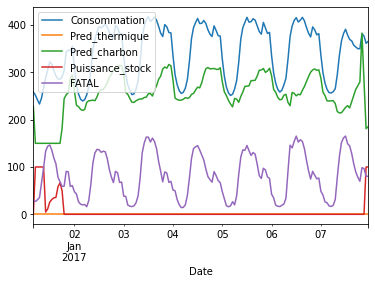

In [51]:
plot_week(result)

Rappel : ce que nous cherchons dans cette partie est le coût annuel de production nécessaire optimisé grâce au stockage d'énergie, un coût en euro donc qui devra être comparé au coût de production (pour la même année) utilisant l'installation de stockage d'énergie actuellement présente à la Réunion (le scénario réel).

Pour cela définissons déjà le scénario réel : les coûts de production et capacités ont été reprises du premier TP sur la PPE (Excel). L'installation de stockage actuelle est estimée à ... kWh. La puissance de charge maximale ou nominale quant à elle inconnue. Nous prendrons l'hypothèse d'une puissance maximale de charge (et décharge) de ... kW sur l'ensmble des installations. 
Cette hypothèse se base sur le ratio courant entre puissance nominale et capacité de batterie, multiplié par la capacité installé. Nous pouvons voir les installations de stockage comme une énorme batterie avec des cellules indépendantes et que nous gérons de façon à ce que la puissace de charge ou décharge totale respecte la puissance nominale de chaque cellule (en chargeant certaines, déchargeant d'autres et laissant le reste de côté). C'est un principe utilisé dans les EMS des home-batteries par exemple dans les batteries Tesla.

In [29]:
# calculer le coût pour l'année 2017 avec les valeurs normales
print("Production thermique (MW): ", {np.sum(result["Pred_thermique"])})
print("Production charbon (MW): ", {np.sum(result["Pred_charbon"])})
print(
    np.sum(result["Pred_thermique"]) * cost_ther
    + np.sum(result["Pred_charbon"]) * cost_char
)
reference_cost = (
    np.sum(result["Pred_thermique"]) * cost_ther
    + np.sum(result["Pred_charbon"]) * cost_char
)

Production thermique (MW):  {0.0}
Production charbon (MW):  {41776.375}
6266456.25


Nous trouvons avec ceci un coût annuel de production de ...€ pour cette année 2017.
**Attention** : dès que nous modifierons des paramètres (puissances, capacités, consommation), nous devrons recalculer cette donnée de référence. 

In [57]:
# reference_cost = ...
def annual_cost(stockage, reference_cost, **kwargs):
    cost_ther = kwargs["cost_ther"] if "cost_ther" in kwargs.keys() else 300
    cost_char = kwargs["cost_char"] if "cost_char" in kwargs.keys() else 150
    week = df.loc["2017-01-01":"2017-01-07"]
    result = solve_week(week, capa_stock=stockage, **kwargs)
    cost = (
        np.sum(result["Pred_thermique"]) * cost_ther
        + np.sum(result["Pred_charbon"]) * cost_char
    )
    return cost - reference_cost

Face à ce coût de production modifié par l'installation de stockage, il faut aussi évaluer le coût fixe annuel de cette installation de stockage supplémentaire pour parler de rentabilité.

## Optimisation de l'installation de stockage

À partir de cette fonction qui modélise la rentabilité d'une installation de stockage selon la capacité installée, nous cherchons à trouver l'installation (en terme de capacité) qui maximise la rentabilité.
Puisque chaque appel à notre fonction demande beaucoup de ressource (en temps de calcul), nous voulons réaliser cette optimisation en limitant le nombre d'appel à la fonction. De plus, cette fonction est considérée comme une boîte noire, nous ne pouvons en tirer de gradient.

*Note :* la fonction ici ne coûte en réalité pas excessivement cher, mais puisque plus tard cette évaluation de la rentabilité prendre compte de l'évolution du parc de production, du mode d'utilisation du stockage sur le coût opérationnel, la fonction sera en réalité effectivement gourmande en ressources.

In [62]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


def fun(point):
    return np.atleast_2d((point - 3.5) * np.sin((point - 3.5) / (np.pi)))


X_plot = np.atleast_2d(np.linspace(0, 25, 10000)).T
Y_plot = fun(X_plot)

In [59]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel_local = RBF()
gp = GaussianProcessRegressor(kernel=kernel_local)

x_data = np.atleast_2d([0, 7, 25]).T
y_data = fun(x_data)
gp.fit(x_data, y_data)
# print("score : ", gp.score(x_data, y_data))
print("hyperparameters : ", gp.kernel_.theta)

hyperparameters :  [0.]


In [60]:
from smt.surrogate_models import KRG

gpr = KRG(theta0=[1e-2] * x_data.shape[1], print_prediction=False)
gpr.set_training_values(x_data, y_data)

gpr.train()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0081730


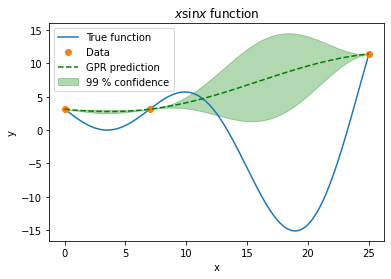

In [63]:
Y_GP_plot = gpr.predict_values(X_plot)
sig_GP_plot = gpr.predict_variances(X_plot)

fig = plt.figure()
ax = fig.add_subplot(111)
(true_fun,) = ax.plot(X_plot, Y_plot)
(data,) = ax.plot(x_data, y_data, linestyle="", marker="o")
(gp,) = ax.plot(X_plot, Y_GP_plot, linestyle="--", color="g")
sig_plus = Y_GP_plot + 3 * np.atleast_2d(sig_GP_plot)
sig_moins = Y_GP_plot - 3 * np.atleast_2d(sig_GP_plot)
un_gp = ax.fill_between(
    X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
)
lines = [true_fun, data, gp, un_gp]
ax.set_title("$x \sin{x}$ function")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(lines, ["True function", "Data", "GPR prediction", "99 % confidence"])
plt.show()

In [67]:
from scipy.stats import norm
from scipy.optimize import minimize

# Expected Improvement function
def EI(GP, points, f_min):
    pred_mu = GP.predict_values(points)
    pred_sig = GP.predict_variances(points)
    args0 = (f_min - pred_mu) / np.atleast_2d(pred_sig)
    args1 = (f_min - pred_mu) * norm.cdf(args0)
    args2 = np.atleast_2d(pred_sig) * norm.pdf(args0)
    ei = args1 + args2
    return ei.ravel()

In [68]:
n_iter = 10


def EGO(n_iter, x_data, y_data, fun):
    for k in range(n_iter):

        # model
        GP = KRG(
            theta0=[1e-2] * x_data.shape[1], print_prediction=False, print_global=False
        )
        GP.set_training_values(x_data, y_data)
        GP.train()

        # fmin
        f_min = np.min(y_data)

        # find x arg max EI
        obj_EI = lambda x: -EI(GP, x, f_min)
        # different starting for non local max
        x_start = np.random.rand(15) * 25
        opt_all = np.array(
            [
                minimize(obj_k, x_st, method="SLSQP", bounds=[(0, 25)])
                for x_st in x_start
            ]
        )
        opt_success = opt_all[[opt_i["success"] for opt_i in opt_all]]
        obj_success = np.array([opt_i["fun"] for opt_i in opt_success])
        ind_min = np.argmin(obj_success)
        opt = opt_success[ind_min]
        x_opt = opt["x"]

        # evaluation
        y_opt = fun(x_opt)

        # concat
        y_data = np.append(y_data, y_opt)
        x_data = np.append(x_data, x_opt)
    ind_best = np.argmin(y_data)
    x_opt = x_data[ind_best]
    y_opt = y_data[ind_best]
    return x_opt, y_opt

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0047224
Results : X = [3.66393348], Y = [[0.00855044]]


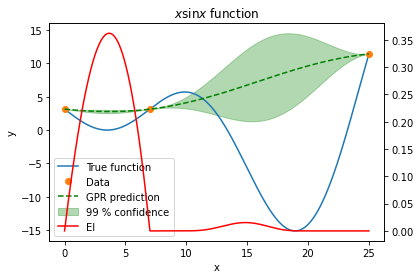

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 4
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0068789
Results : X = [16.09847691], Y = [[-9.61821817]]


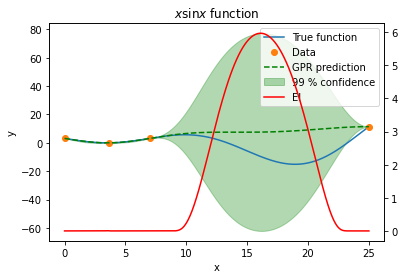

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 5
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0060248
Results : X = [11.97803606], Y = [[3.63374213]]


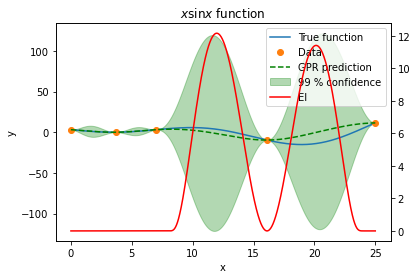

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 6
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0051000
Results : X = [18.58652792], Y = [[-15.02573689]]


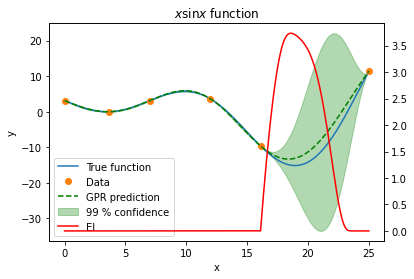

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 7
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0047641
Results : X = [20.07807443], Y = [[-14.00541487]]


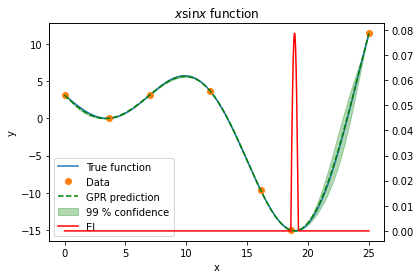

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 8
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0054851
Results : X = [18.93088746], Y = [[-15.12508772]]


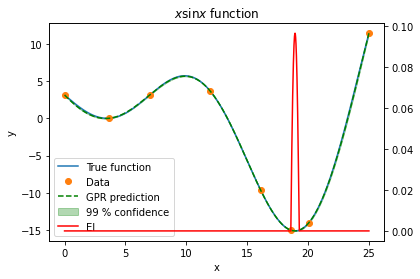

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 9
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0068269
Results : X = [21.16622754], Y = [[-10.82937425]]


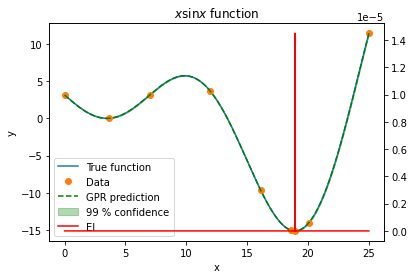

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 10
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0047491
Results : X = [24.56599834], Y = [[8.63467988]]


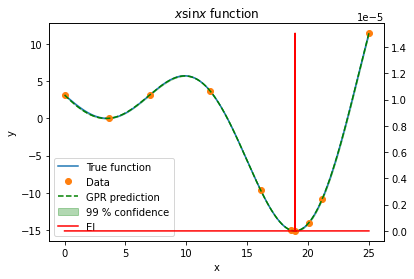

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 11
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0040302
Results : X = [12.76749117], Y = [[1.76534012]]


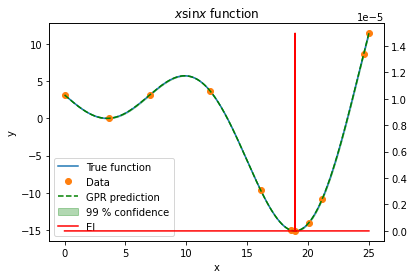

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 12
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0058811
Results : X = [23.46489373], Y = [[1.43299961]]


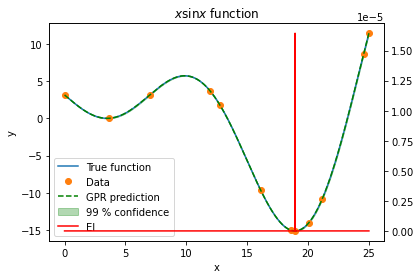

In [70]:
x_data = np.atleast_2d([0, 7, 25]).T
y_data = fun(x_data)

for k in range(n_iter):
    x_start = np.random.rand(15) * 25
    f_min_k = np.min(y_data)
    gpr.set_training_values(x_data, y_data)
    gpr.train()
    obj_k = lambda x: -EI(gpr, np.atleast_2d(x), f_min_k)

    opt_all = np.array(
        [minimize(obj_k, x_st, method="SLSQP", bounds=[(0, 25)]) for x_st in x_start]
    )
    opt_success = opt_all[[opt_i["success"] for opt_i in opt_all]]
    obj_success = np.array([opt_i["fun"] for opt_i in opt_success])
    ind_min = np.argmin(obj_success)
    opt = opt_success[ind_min]
    x_et_k = opt["x"]

    y_et_k = fun(x_et_k)

    print("Results : X = %s, Y = %s" % (x_et_k, y_et_k))

    Y_GP_plot = gpr.predict_values(X_plot)
    sig_GP_Plot = gpr.predict_variances(X_plot)
    Y_EI_plot = EI(gpr, X_plot, np.min(y_data))

    fig = plt.figure()
    ax = fig.add_subplot(111)
    (true_fun,) = ax.plot(X_plot, Y_plot)
    (data,) = ax.plot(x_data, y_data, linestyle="", marker="o")
    (gp,) = ax.plot(X_plot, Y_GP_plot, linestyle="--", color="g")
    sig_plus = Y_GP_plot + 3 * np.atleast_2d(sig_GP_Plot)
    sig_moins = Y_GP_plot - 3 * np.atleast_2d(sig_GP_Plot)
    un_gp = ax.fill_between(
        X_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
    )
    ax1 = ax.twinx()
    (ei,) = ax1.plot(X_plot, Y_EI_plot, color="red")
    lines = [true_fun, data, gp, un_gp, ei]
    ax.set_title("$x \sin{x}$ function")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend(
        lines, ["True function", "Data", "GPR prediction", "99 % confidence", "EI"]
    )
    plt.show()

    y_data = np.atleast_2d(np.append(y_data, y_et_k)).T
    x_data = np.atleast_2d(np.append(x_data, x_et_k)).T

ind_best = np.argmin(y_data)
x_opt = x_data[ind_best]
y_opt = y_data[ind_best]